<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/Predict_FX_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [3]:
!pip3 install torch

In [4]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


In [64]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [5]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [68]:
import copy

# Import et préparation des données

##Import des données depuis le Drive

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# https://drive.google.com/file/d/1g6GbXJB-NxBt3F-1ftMz2SwzFQ_GU5oZ/view?usp=sharing
# FX_HFData.xlsx
downloaded = drive.CreateFile({'id':"1g6GbXJB-NxBt3F-1ftMz2SwzFQ_GU5oZ"})   # replace the id with id of file you want to access
downloaded.GetContentFile('FX_HFData.xlsx')

## Chargement du fichier et nettoyage des données


In [8]:
df = pd.read_excel('FX_HFData.xlsx',sheet_name='Daily All',dtype={' ': datetime.date, 'USDCAD Curncy': float})
df = df.drop(columns=['EURUSD Curncy','GBPUSD Curncy','USDJPY Curncy','USDCHF Curncy',
                      'AUDUSD Curncy','USDSEK Curncy','USDNOK Curncy','NZDUSD Curncy','USDSGD Curncy'])
df = df.dropna()
df.columns = ['date', 'X']
df.describe()

,X
count,10792.000000
mean,1.264400
std,0.149636
min,0.920350
25%,1.164600
50%,1.270250
75%,1.365000
max,1.613500


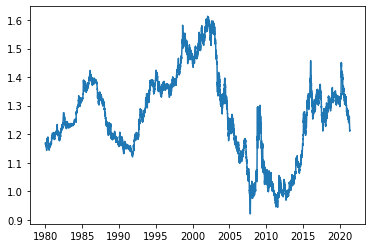

In [9]:
plt.figure()
plt.plot(df['date'],df['X'])

## Création des datasets (train, validate et test)

In [10]:
seq_len = 8 # 7 premiers sont les séquences d'entrée et le huitieme est la cible à prédire
partition = round(df.shape[0]/seq_len)
dfs = np.array_split(df['X'].values, partition)

In [22]:
print(dfs[1])

[1.1663 1.1658 1.1644 1.1613 1.1617 1.1611 1.159  1.1603]


At this point, we need to divide the dataset into three subsets:

<ol>
<li> <b> Train</b> (60% of the dataset): used to train the classification model. </li>   
<li> <b> Validation</b> (20% of the dataset): used to evaluate hyper-parameters on held-out data. </li>   
<li> <b> Test</b> (20% of the dataset): used to evaluate the generalization performance of the chosen model on held-out data. </li>
</ol>

In [80]:
train, validate, test = np.split(dfs, [int(.6*len(dfs)), int(.8*len(dfs))])

In [120]:
def split_x_y_in_torch(dfs):
  X = []
  Y = []
  for row in dfs:
    X.append([row[0:seq_len-1]])
    Y.append([row[seq_len-1]])
  X = np.array(X)
  Y = np.array(Y)
  return torch.from_numpy(X.transpose(0,2,1)).float(), torch.from_numpy(Y).float()

In [121]:
X_train, y_train = split_x_y_in_torch(train)
X_validate, y_validate = split_x_y_in_torch(validate)
X_test, y_test = split_x_y_in_torch(test)

print(X_train[1])
print(y_train[1])
print(X_validate[1])
print(y_validate[1])
print(X_test[1])
print(y_test[1])

tensor([[1.1663],
        [1.1658],
        [1.1644],
        [1.1613],
        [1.1617],
        [1.1611],
        [1.1590]])
tensor([1.1603])
tensor([[1.2087],
        [1.2068],
        [1.1976],
        [1.1947],
        [1.1992],
        [1.1939],
        [1.1961]])
tensor([1.1926])
tensor([[1.0018],
        [1.0009],
        [1.0064],
        [1.0107],
        [1.0112],
        [1.0167],
        [1.0185]])
tensor([1.0216])


In [122]:
def standardize(X, mean=None, std=None):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()

    if mean == None:
      mean = torch.mean(X)
    if std == None:
      std = torch.std(X)
      
    Xs = (X-mean) / std

    return Xs, mean, std

In [126]:
mean = np.mean(dfs)
std = np.std(dfs)

Xs_train, Xs_train_mean, Xs_train_std = standardize(X_train, mean, std)
ys_train, ys_train_mean, ys_train_std = standardize(y_train, mean, std)

Xs_validate, Xs_validate_mean, Xs_validate_std = standardize(X_validate, mean, std)
ys_validate, ys_validate_mean, ys_validate_std = standardize(y_validate, mean, std)

Xs_test, Xs_test_mean, Xs_test_std = standardize(X_test, mean, std)
ys_test, ys_test_mean, ys_test_std = standardize(y_test, mean, std)

print(Xs_train[0])
print(Xs_train_mean)
print(Xs_train_std)
print(ys_train[0])

print(Xs_validate[1])
print(Xs_validate_mean)
print(Xs_validate_std)
print(ys_validate[1])

print(Xs_test[200])
print(Xs_test_mean)
print(Xs_test_std)
print(ys_test[200])

tensor([[-0.6590],
        [-0.6289],
        [-0.6396],
        [-0.6349],
        [-0.6322],
        [-0.6402],
        [-0.6643]])
1.2643998350630095
0.14962915972491428
tensor([-0.6643])
tensor([[-0.3723],
        [-0.3850],
        [-0.4468],
        [-0.4662],
        [-0.4357],
        [-0.4715],
        [-0.4568]])
1.2643998350630095
0.14962915972491428
tensor([-0.4795])
tensor([[0.5248],
        [0.5079],
        [0.4925],
        [0.5115],
        [0.5306],
        [0.4712],
        [0.4434]])
1.2643998350630095
0.14962915972491428
tensor([0.4631])


# Implémentation du modèle RNN

## Modèle RNN
Implement an RNN network using the [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hidden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [124]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn_layer = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)
        self.print_debug_flag = False

    def print_debug(self,text,var):
      if self.print_debug_flag == True:
        print(text,var)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        self.print_debug('x:',x)

        x = torch.transpose(x, 0, 1)

        self.print_debug('x\':',x)

        output, hidden = self.rnn_layer(x) #hidden c'est le dernier h (vecteur)
                                            # si on veut initialiser un autre rnn avec les parametres déjà appris

        self.print_debug('hidden:',hidden)
        self.print_debug('output:',output)
        self.print_debug('output[-1]:',output[-1])
        self.print_debug('linear_layer(output):',self.linear_layer(output))
        self.print_debug('linear_layer(output[-1]):',self.linear_layer(output[-1]))

        output = output[-1]
        pred = self.linear_layer(output)
        
        self.print_debug('pred:',pred)

        return pred

In [125]:
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Transfer the data to the proper device
Xs_train = Xs_train.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs_train)
print("Size of input data: {}".format(Xs_train.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)
        
# x has size of (n_samples=batch_size, seq_len, input_dim)
# The RNN's input must be of size (seq_len, batch_size, input_dim)
print(Xs_train.shape)
Xs_train_t = torch.transpose(Xs_train, 0, 1)
print(Xs_train_t.shape)
print(ys_train[0])
print(y_pred[0])

Size of input data: torch.Size([809, 7, 1])
Size of predictions: torch.Size([809, 1])
torch.Size([809, 7, 1])
torch.Size([7, 809, 1])
tensor([-0.6643])
tensor([0.1326], device='cuda:0', grad_fn=<SelectBackward>)


# Zone de tests

In [119]:
X = []
Y = []

for row in dfs:
  X.append([row[0:seq_len-1]])
  Y.append([row[seq_len-1]])
X = np.array(X)
Y = np.array(Y)
print(X[0])
torch_X = torch.from_numpy(X.transpose(0,2,1)).float()
print(torch_X.shape)
print(torch_X[0,:,0])

[[1.1658 1.1703 1.1687 1.1694 1.1698 1.1686 1.165 ]]
torch.Size([1349, 7, 1])
tensor([1.1658, 1.1703, 1.1687, 1.1694, 1.1698, 1.1686, 1.1650])
